In [62]:
from dotenv import load_dotenv
from typing import Annotated, Sequence
import operator, json
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import StateGraph, END, START 
from langgraph.graph.message import add_messages 
from langgraph.prebuilt import ToolNode, tools_condition 
from langchain_core.tools import tool 
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

In [2]:
load_dotenv()

True

In [4]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [28]:
@tool
def multiply(first_number: int, second_number: int):
    """multiply two integer numbers"""
    return first_number * second_number

In [29]:
multiply.invoke({"first_number": 24, "second_number": 364})

8736

In [30]:
@tool
def search(query: str):
    """perform the web search on the user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [31]:
search.invoke("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies - USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. H

In [53]:
tools = [search]

In [54]:
llm_with_tools = llm.bind_tools(tools)

In [55]:
tool_mapping = {tool.name: tool for tool in tools}

In [56]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000253B9629300>)}

In [57]:
response = llm_with_tools.invoke("who is a current president of USA?")

In [37]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sqa9zx7bd', 'function': {'arguments': '{"query":"current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 279, 'total_tokens': 295, 'completion_time': 0.04645047, 'prompt_time': 0.013891288, 'queue_time': 0.091229954, 'total_time': 0.060341758}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d7bc5730-ae0e-46bd-9e54-375f758dd51c-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'sqa9zx7bd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 279, 'output_tokens': 16, 'total_tokens': 295})

In [38]:
tool_details = response.additional_kwargs.get("tool_calls")

In [39]:
tool_details

[{'id': 'sqa9zx7bd',
  'function': {'arguments': '{"query":"current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [40]:
tool_details[0]["function"]["name"]

'search'

In [41]:
tool_details[0]["function"]["arguments"]

'{"query":"current president of USA"}'

In [42]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. H

In [45]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [46]:
def invoke_model(state: AgentState):
    messages = state["messages"]
    question = messages[-1]
    return {"messages": [llm_with_tools.invoke(question)]}

In [59]:
def invoke_tool(state: AgentState):
    tool_details = state["messages"][-1].additional_kwargs.get("tool_calls", [])[0]

    if tool_details is None:
        raise Exception("no tool call found")

    tool_name = tool_details["function"]["name"]
    args = json.loads(tool_details["function"]["arguments"])

    print(f"Selected tool: {tool_name}")

    if tool_name == "search":
        response = input(prompt="[y/n] continue with expensive web search? ")
        if response == "n":
            raise Exception("web search discard")

    response = tool_mapping[tool_name].invoke(args)
    return {"messages": [response]}


In [60]:
def router(state):
    tool_calls = state["messages"][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool" 
    else:
        return "end"

In [61]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant", router, {"tool": "tool", "end": END})
graph.add_edge("tool", END)
#graph.add_edge("tool", "ai_assistant")
graph.set_entry_point("ai_assistant")

app = graph.compile()

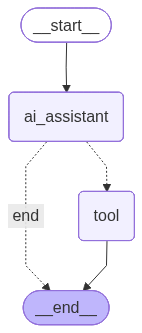

In [62]:
app

In [63]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '30ayj9561', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 221, 'total_tokens': 238, 'completion_time': 0.065270602, 'prompt_time': 0.010937769, 'queue_time': 0.042286192, 'total_time': 0.076208371}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--e8518c57-1ad3-4787-91f8-62216c8903ea-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': '30ayj9561', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 17, 'total_tokens': 238})]}
----
Selected tool: search
{'messages': [[{'title': 'Presidential candidates, 2028 - Ballotpedia', 'url': 'https://ballotpedia.org/Presidentia

In [23]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [24]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [25]:
tavily = TavilySearchResults()

In [26]:
tools = [tavily]

In [27]:
llm_with_tools = llm.bind_tools(tools)

In [28]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [29]:
memory = MemorySaver()

In [30]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)
tool_node = ToolNode(tools = tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

app2 = graph_builder.compile(
    checkpointer = memory,
    interrupt_before = ["tools"]
)

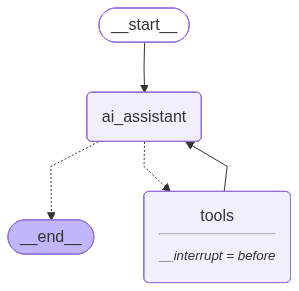

In [31]:
app2

In [32]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [33]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode = "values"
)

In [34]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mqad48zjs)
 Call ID: mqad48zjs
  Args:
    query: current capital of India


In [35]:
snapshot = app2.get_state(config)

In [36]:
snapshot.next

('tools',)

In [37]:
last_message = snapshot.values["messages"][-1]

In [38]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current capital of India'},
  'id': 'mqad48zjs',
  'type': 'tool_call'}]

In [39]:
events = app2.stream(None, config, stream_mode = "values")

In [40]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mqad48zjs)
 Call ID: mqad48zjs
  Args:
    query: current capital of India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is the Capital of India?", "url": "https://www.worldatlas.com/articles/what-is-the-capital-of-india.html", "content": "The capital city or the National Capital Territory (NCT) of India is New Delhi. Delhi is divided into two parts; the Old Delhi and New Delhi. The Old Delhi was founded in 1639 while the New Delhi was established on December 15, 1911. New Delhi is located in the north-central part of India and is adjacent south of Delhi city. Initially, the capital city was in Kolkata when King George V of Britain ordered that the capital be moved to Delhi in 1911. The construction of New Delhi started in 1912, [...] but the new capital was dedicated in 1931. Del

In [41]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [42]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode = "values"
)

In [43]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f8g8pp3x3)
 Call ID: f8g8pp3x3
  Args:
    query: New Delhi weather


In [44]:
snapshot = app2.get_state(config)

In [45]:
snapshot.next

('tools',)

In [46]:
last_message = snapshot.values["messages"][-1]

In [47]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'New Delhi weather'},
  'id': 'f8g8pp3x3',
  'type': 'tool_call'}]

In [48]:
events = app2.stream(None, config, stream_mode = "values")

In [49]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f8g8pp3x3)
 Call ID: f8g8pp3x3
  Args:
    query: New Delhi weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Delhi Weather: Dense Fog Persists with Visibility 50–200 Metres ...", "url": "https://www.outlookindia.com/national/delhi-weather-dense-fog-persists-with-visibility-50200-metres-aqi-very-poor-at-310330", "content": "Delhi is continuing to struggle with dense fog on Wednesday, December 10, 2025, with visibility severely reduced to 50–200 metres during early morning and late evening hours, creating hazardous conditions for commuters and road traffic. The minimum temperature has settled around 8–9°C, marking another cold morning, while the maximum is expected to reach 25°C, creating a sharp day-night temperature contrast of over 15°C. Humidity levels remain extremely high at 9

In [50]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='67c49fb7-0c88-49d1-8d0f-a30aa69b78a7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mqad48zjs', 'function': {'arguments': '{"query":"current capital of India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.053470424, 'prompt_time': 0.02420479, 'queue_time': 0.093637854, 'total_time': 0.077675214}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--6fcf8437-9fba-43da-9446-0a81546b7f4e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current capital of India'}, 'id': 'mqad48zjs', 'type': 'tool_call'}], usage_metadata={'i

In [51]:
snapshot = app2.get_state(config)

In [52]:
snapshot.next

()

In [53]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [54]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode = "values"
)

In [55]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4t74yvtgj)
 Call ID: 4t74yvtgj
  Args:
    query: New Delhi recent news


In [56]:
snapshot = app2.get_state(config)

In [57]:
current_message = snapshot.values["messages"][-1]

In [58]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4t74yvtgj)
 Call ID: 4t74yvtgj
  Args:
    query: New Delhi recent news


In [59]:
tool_call_id = current_message.tool_calls[0]["id"]

In [60]:
tool_call_id

'4t74yvtgj'

In [61]:
answer = "it is just related to raining which is happening on daily basis"

In [63]:
new_messages = [
    ToolMessage(content = answer, tool_call_id = tool_call_id),
    AIMessage(content = answer)
]

In [64]:
app2.update_state(
    config,
    {"messages": new_messages}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d5b83-48d7-6f7d-800c-9e88dbfdfb70'}}

In [65]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happening on daily basis', additional_kwargs={}, response_metadata={}, id='1d9d27cc-f68c-4d00-820d-143ac6a69dca')]
